In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, numpy as np, random, math, json, gc
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

PROJECT_DIR = "/content/drive/MyDrive/Acoustic_C80_Project"
base_dir    = "/content/drive/MyDrive/Task_2"

DIRS = {
    "root": PROJECT_DIR,
    "checkpoints": os.path.join(PROJECT_DIR, "checkpoints"),
    "outputs": os.path.join(PROJECT_DIR, "outputs_completed"),
    "reports": os.path.join(PROJECT_DIR, "reports"),
}
for p in DIRS.values():
    os.makedirs(p, exist_ok=True)

file_paths = sorted(glob.glob(os.path.join(base_dir, "*", "*.npy")))
print("Toplam npy:", len(file_paths))

SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

N_ROWS, N_COLS = 11, 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE=224
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
])

FREQS = [125, 250, 1000, 2000, 4000]
freq_to_idx = {f:i for i,f in enumerate(FREQS)}
def freq_from_path(path: str) -> int:
    base = os.path.basename(path)
    for f in FREQS:
        if str(f) in base:
            return f
    return -1

def rc_norm(r, c, n_rows=11, n_cols=24):
    return np.array([r/(n_rows-1), c/(n_cols-1)], dtype=np.float32)

Mounted at /content/drive
Toplam npy: 18


In [2]:
samples = []
for fi, fp in enumerate(file_paths):
    d = np.load(fp, allow_pickle=True).item()
    am = d['acoustic_matrix']; mm = d['mel_matrix']
    assert am.shape==(N_ROWS,N_COLS) and mm.shape==(N_ROWS,N_COLS)
    for r in range(N_ROWS):
        for c in range(N_COLS):
            val = am[r,c]
            has_label = not (val is None or (isinstance(val, float) and math.isnan(val)))
            has_img = (mm[r,c] is not None)
            samples.append((fi,r,c,has_img,has_label))

def get_group(path): return os.path.basename(os.path.dirname(path))
file_groups = [get_group(fp) for fp in file_paths]
unique_groups = sorted(set(file_groups))

train_index = [(fi,r,c) for (fi,r,c,hi,hl) in samples if hi and hl]
random.seed(42)
val_groups = set(random.sample(unique_groups, max(1, int(0.2*len(unique_groups)))))
fi_to_group = {fi:file_groups[fi] for fi in range(len(file_paths))}
train_tuples = [(fi,r,c) for (fi,r,c) in train_index if fi_to_group[fi] not in val_groups]
val_tuples   = [(fi,r,c) for (fi,r,c) in train_index if fi_to_group[fi] in val_groups]

print(f"Train: {len(train_tuples)} | Valid: {len(val_tuples)} | Valid gruplar: {sorted(val_groups)}")

Train: 720 | Valid: 360 | Valid gruplar: ['alev_atali_18_numpy_matrices3']


In [3]:
class MelC80Dataset(Dataset):
    def __init__(self, tuples, file_paths, transform=img_transform, use_rc=True):
        self.tuples = tuples
        self.files = file_paths
        self.transform = transform
        self.use_rc = use_rc

    def __len__(self): return len(self.tuples)

    def __getitem__(self, idx):
        fi, r, c = self.tuples[idx]
        d = np.load(self.files[fi], allow_pickle=True).item()
        am = d['acoustic_matrix']; mm = d['mel_matrix']

        img = mm[r,c]
        x = img.astype(np.float32)
        if x.max()>1.5: x = x/255.0
        if x.shape[-1]==4: x = x[...,:3]
        x = self.transform(x)

        y = np.float32(am[r,c])

        f = freq_from_path(self.files[fi])
        foh = np.zeros(len(FREQS), dtype=np.float32)
        if f in freq_to_idx: foh[freq_to_idx[f]] = 1.0
        foh_t = torch.from_numpy(foh)

        if self.use_rc:
            rc_t = torch.from_numpy(rc_norm(r,c,N_ROWS,N_COLS))
            return x, foh_t, rc_t, torch.tensor(y, dtype=torch.float32)
        else:
            return x, foh_t, torch.tensor(y, dtype=torch.float32)

train_loader = DataLoader(MelC80Dataset(train_tuples, file_paths, use_rc=True),
                          batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(MelC80Dataset(val_tuples,   file_paths, use_rc=True),
                          batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
class Regressor(nn.Module):
    def __init__(self, use_rc=True):
        super().__init__()
        self.use_rc = use_rc

        backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        in_feats = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        # freq embedding
        self.freq_head = nn.Sequential(
            nn.Linear(len(FREQS), 64), nn.ReLU(True),
            nn.Linear(64, 64), nn.ReLU(True),
        )

        # FiLM: backbone çıkış boyutuna uygun scale/shift
        self.film_gamma = nn.Linear(64, in_feats)  # scale
        self.film_beta  = nn.Linear(64, in_feats)  # shift

        if use_rc:
            self.rc_head = nn.Sequential(nn.Linear(2, 32), nn.ReLU(True))
            meta_feats = 64 + 32
        else:
            meta_feats = 64

        self.head = nn.Sequential(
            nn.Linear(in_feats + meta_feats, 256),
            nn.ReLU(True),
            nn.Dropout(0.35),
            nn.Linear(256, 1)
        )

    def forward(self, x, foh, rc=None):
        feats = self.backbone(x)                 # [B, in_feats]
        femb  = self.freq_head(foh)              # [B, 64]

        # FiLM uygulaması
        gamma = self.film_gamma(femb)            # [B, in_feats]
        beta  = self.film_beta(femb)             # [B, in_feats]
        feats = feats * (1.0 + gamma) + beta

        if self.use_rc and rc is not None:
            rr = self.rc_head(rc)
            z  = torch.cat([feats, femb, rr], dim=1)
        else:
            z  = torch.cat([feats, femb], dim=1)
        return self.head(z).squeeze(1)


In [13]:
import os, math
from tqdm import tqdm
import torch

# Ayarlar (opsiyonel)
USE_WEIGHTED_LOSS = True
WEIGHT_LOW        = 1.3

BEST_CKPT = os.path.join(DIRS["checkpoints"], "best_c80.pth")
os.makedirs(DIRS["checkpoints"], exist_ok=True)
print("Checkpoint yolu:", BEST_CKPT)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    mae_loss, mse_loss, n = 0.0, 0.0, 0
    for x, foh, rc, y in loader:
        x, foh, rc, y = x.to(device), foh.to(device), rc.to(device), y.to(device)
        with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
            pred = model(x, foh, rc)
            diff = pred - y
        mae_loss += torch.sum(torch.abs(diff)).item()
        mse_loss += torch.sum(diff * diff).item()
        n += y.numel()
    return mae_loss / n, math.sqrt(mse_loss / n)

best_val = float('inf')
patience = 10
wait = 0
EPOCHS = 20

for epoch in range(1, EPOCHS + 1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for x, foh, rc, y in pbar:
        x, foh, rc, y = x.to(device), foh.to(device), rc.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
            pred = model(x, foh, rc)

            if USE_WEIGHTED_LOSS:
                # 125 ve 250 Hz örneklerini ağır cezalandır
                freq_idx = torch.argmax(foh, dim=1)  # [B]
                is_low = (freq_idx == freq_to_idx[125]) | (freq_idx == freq_to_idx[250])
                w = torch.ones_like(y)
                w[is_low] = WEIGHT_LOW
                loss = torch.mean(w * torch.abs(pred - y))  # ağırlıklı MAE
            else:
                loss = loss_fn(pred, y)  # düz MAE (loss_fn = nn.L1Loss())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        pbar.set_postfix(loss=float(loss.detach().cpu()))

    val_mae, val_rmse = evaluate(val_loader)
    print(f"Val MAE: {val_mae:.3f} | Val RMSE: {val_rmse:.3f}")

    if val_mae < best_val - 1e-4:
        best_val = val_mae
        wait = 0
        torch.save(model.state_dict(), BEST_CKPT)
        print(">> En iyi model Drive’a kaydedildi.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
model.eval()
print("Best model yüklendi:", BEST_CKPT)

Checkpoint yolu: /content/drive/MyDrive/Acoustic_C80_Project/checkpoints/best_c80.pth


Epoch 1/20: 100%|██████████| 45/45 [06:27<00:00,  8.62s/it, loss=2.12]


Val MAE: 1.891 | Val RMSE: 2.460
>> En iyi model Drive’a kaydedildi.


Epoch 2/20: 100%|██████████| 45/45 [06:31<00:00,  8.69s/it, loss=2.24]


Val MAE: 1.762 | Val RMSE: 2.378
>> En iyi model Drive’a kaydedildi.


Epoch 3/20: 100%|██████████| 45/45 [06:29<00:00,  8.65s/it, loss=1.82]


Val MAE: 1.504 | Val RMSE: 2.017
>> En iyi model Drive’a kaydedildi.


Epoch 4/20: 100%|██████████| 45/45 [06:25<00:00,  8.56s/it, loss=1.39]


Val MAE: 1.774 | Val RMSE: 2.346


Epoch 5/20: 100%|██████████| 45/45 [06:23<00:00,  8.51s/it, loss=1.43]


Val MAE: 1.695 | Val RMSE: 2.154


Epoch 6/20: 100%|██████████| 45/45 [06:26<00:00,  8.58s/it, loss=1.35]


Val MAE: 1.760 | Val RMSE: 2.409


Epoch 7/20: 100%|██████████| 45/45 [06:25<00:00,  8.57s/it, loss=1.3]


Val MAE: 1.476 | Val RMSE: 1.969
>> En iyi model Drive’a kaydedildi.


Epoch 8/20:  93%|█████████▎| 42/45 [06:04<00:26,  8.67s/it, loss=1.78]


KeyboardInterrupt: 

In [14]:
BEST_CKPT = os.path.join(DIRS["checkpoints"], "best_c80.pth")
model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
model.eval()
print("Best checkpoint yüklendi:", BEST_CKPT)

Best checkpoint yüklendi: /content/drive/MyDrive/Acoustic_C80_Project/checkpoints/best_c80.pth


In [15]:
from heapq import nsmallest
import pandas as pd

def spatial_idw_fill(acoustic_matrix, k=6, eps=1e-6, power=2.0):
    arr = acoustic_matrix.copy()
    known = np.argwhere(~np.isnan(arr))
    if len(known)==0: return arr
    for r in range(N_ROWS):
        for c in range(N_COLS):
            if np.isnan(arr[r,c]):
                dists=[]
                for (rr,cc) in known:
                    d = math.hypot(r-rr, c-cc);  d = max(d, eps)
                    dists.append(((rr,cc), d))
                nearest = nsmallest(k, dists, key=lambda t:t[1])
                weights = np.array([1.0/(d**power) for (_,d) in nearest], dtype=np.float64)
                vals    = np.array([arr[rc[0],rc[1]] for (rc,_) in nearest], dtype=np.float64)
                arr[r,c] = float(np.sum(weights*vals)/np.sum(weights))
    return arr

model.eval()
summary_rows = []
for fi, fp in enumerate(file_paths):
    d = np.load(fp, allow_pickle=True).item()
    am = d['acoustic_matrix'].astype(np.float32)
    mm = d['mel_matrix']
    pred_matrix = am.copy()

    # frekans one-hot
    f = freq_from_path(fp)
    foh = np.zeros(len(FREQS), dtype=np.float32)
    if f in freq_to_idx: foh[freq_to_idx[f]] = 1.0
    foh_t = torch.from_numpy(foh).unsqueeze(0).to(device)

    # model tahmini
    to_predict=[]; coords=[]
    for r in range(N_ROWS):
        for c in range(N_COLS):
            if (mm[r,c] is not None) and (np.isnan(pred_matrix[r,c])):
                img = mm[r,c].astype(np.float32)
                if img.max()>1.5: img = img/255.0
                if img.shape[-1]==4: img = img[...,:3]
                xt = img_transform(img).unsqueeze(0).to(device)
                rc_t = torch.from_numpy(rc_norm(r,c,N_ROWS,N_COLS)).unsqueeze(0).to(device)
                to_predict.append((xt, foh_t, rc_t)); coords.append((r,c))

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
        for i in range(0, len(to_predict), 32):
            bx = torch.cat([t[0] for t in to_predict[i:i+32]], dim=0)
            bf = torch.cat([t[1] for t in to_predict[i:i+32]], dim=0)
            br = torch.cat([t[2] for t in to_predict[i:i+32]], dim=0)
            out = model(bx, bf, br).detach().cpu().numpy()
            for j, val in enumerate(out):
                rr, cc = coords[i+j]
                pred_matrix[rr,cc] = float(val)

    # kalan NaN → IDW
    if np.isnan(pred_matrix).any():
        pred_matrix = spatial_idw_fill(pred_matrix, k=6, power=2.0)

    # özet
    summary_rows.append({
        "file": os.path.basename(fp),
        "missing_before": int(np.isnan(am).sum()),
        "missing_after":  int(np.isnan(pred_matrix).sum()),
        "mean_c80_pred":  float(np.nanmean(pred_matrix)),
        "min_c80_pred":   float(np.nanmin(pred_matrix)),
        "max_c80_pred":   float(np.nanmax(pred_matrix)),
    })

    # kaydet
    out_path = os.path.join(DIRS["outputs"], f"{os.path.splitext(os.path.basename(fp))[0]}__completed.npy")
    out_dict = dict(d); out_dict['acoustic_matrix_completed'] = pred_matrix
    np.save(out_path, out_dict)

df = pd.DataFrame(summary_rows)
csv_path = os.path.join(DIRS["reports"], "summary.csv")
df.to_csv(csv_path, index=False)
print("Tamamlanan dosya sayısı:", len(df), "| summary ->", csv_path)
display(df.head())

Tamamlanan dosya sayısı: 18 | summary -> /content/drive/MyDrive/Acoustic_C80_Project/reports/summary.csv


,file,missing_before,missing_after,mean_c80_pred,min_c80_pred,max_c80_pred
0,Konum1_C80_1000Hz.npy,204,0,9.126200,6.02,12.59
1,Konum1_C80_125Hz.npy,204,0,7.267296,0.82,14.25
2,Konum1_C80_2000Hz.npy,204,0,9.225357,6.36,11.99
3,Konum1_C80_250Hz.npy,204,0,8.562583,5.20,10.79
4,Konum1_C80_4000Hz.npy,204,0,8.891688,6.43,12.30


In [16]:
import os, torch, numpy as np

CKPT = os.path.join(DIRS["checkpoints"], "best_c80.pth")
print("Yükleniyor:", CKPT)
sd = torch.load(CKPT, map_location=device)
missing, unexpected = model.load_state_dict(sd, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()
# küçük bir hızlı geçiş: ilk dosyadan mel+etiketli 8 koltuk al
d = np.load(file_paths[0], allow_pickle=True).item()
am = d["acoustic_matrix"].astype(np.float32)
mm = d["mel_matrix"]

batch_x=[]; batch_f=[]; batch_rc=[]; y_true=[]
# dosya adından frekans one-hot
base = os.path.basename(file_paths[0])
foh = np.zeros(len(FREQS), dtype=np.float32)
for f in FREQS:
    if str(f) in base: foh[freq_to_idx[f]]=1.0; break
foh_t = torch.from_numpy(foh).unsqueeze(0).to(device)

cnt=0
for r in range(N_ROWS):
    for c in range(N_COLS):
        if mm[r,c] is not None and not np.isnan(am[r,c]):
            img = mm[r,c].astype(np.float32)
            if img.max()>1.5: img = img/255.0
            if img.shape[-1]==4: img = img[...,:3]
            xt = img_transform(img).unsqueeze(0).to(device)
            rc_t = torch.from_numpy(np.array([r/(N_ROWS-1), c/(N_COLS-1)], dtype=np.float32)).unsqueeze(0).to(device)
            batch_x.append(xt); batch_f.append(foh_t); batch_rc.append(rc_t)
            y_true.append(float(am[r,c]))
            cnt+=1
        if cnt==8: break
    if cnt==8: break

with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
    bx = torch.cat(batch_x, dim=0)
    bf = torch.cat(batch_f, dim=0)
    br = torch.cat(batch_rc, dim=0)
    y_pred = model(bx, bf, br).detach().cpu().numpy()

y_true = np.array(y_true, dtype=np.float32)
y_pred = np.clip(y_pred.astype(np.float32), -10.0, 10.0)
mae = float(np.mean(np.abs(y_true - y_pred)))
rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
acc1 = float(np.mean(np.abs(y_true - y_pred) <= 1.0)*100)
print(f"Hızlı test -> MAE={mae:.3f} | RMSE={rmse:.3f} | ±1dB={acc1:.1f}%")

Yükleniyor: /content/drive/MyDrive/Acoustic_C80_Project/checkpoints/best_c80.pth
Missing keys: []
Unexpected keys: []
Hızlı test -> MAE=1.025 | RMSE=1.209 | ±1dB=62.5%


In [17]:
import os, re, random, numpy as np, torch

def freq_from_filename(fname):
    m = re.search(r"(125|250|1000|2000|4000)", os.path.basename(fname))
    return int(m.group(1)) if m else -1

model.eval()
samples = []
for fp in file_paths:
    d = np.load(fp, allow_pickle=True).item()
    am = d["acoustic_matrix"].astype(np.float32)
    mm = d["mel_matrix"]
    f  = freq_from_filename(fp)
    foh = np.zeros(len(FREQS), dtype=np.float32)
    if f in freq_to_idx: foh[freq_to_idx[f]] = 1.0
    for r in range(N_ROWS):
        for c in range(N_COLS):
            if (mm[r,c] is not None) and (not np.isnan(am[r,c])):
                samples.append((fp, foh.copy(), r, c, float(am[r,c])))

random.shuffle(samples)
samples = samples[:200]  # 200 örnek

X,F,R,Y = [],[],[],[]
for fp, foh, r, c, yt in samples:
    d = np.load(fp, allow_pickle=True).item()
    img = d["mel_matrix"][r,c].astype(np.float32)
    if img.max()>1.5: img = img/255.0
    if img.shape[-1]==4: img = img[...,:3]
    xt = img_transform(img).unsqueeze(0).to(device)
    ft = torch.from_numpy(foh).unsqueeze(0).to(device)
    rt = torch.from_numpy(np.array([r/(N_ROWS-1), c/(N_COLS-1)], np.float32)).unsqueeze(0).to(device)
    X.append(xt); F.append(ft); R.append(rt); Y.append(yt)

with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=(device.type=='cuda')):
    bx = torch.cat(X, dim=0); bf = torch.cat(F, dim=0); br = torch.cat(R, dim=0)
    yp = model(bx, bf, br).detach().cpu().numpy().astype(np.float32)

Y = np.array(Y, np.float32); diff = np.abs(Y - yp)
mae  = float(diff.mean())
rmse = float(np.sqrt(((Y-yp)**2).mean()))
acc1 = float((diff<=1.0).mean()*100)
print(f"Karma hızlı test (200 örnek) -> MAE={mae:.3f} | RMSE={rmse:.3f} | ±1dB={acc1:.1f}%")

Karma hızlı test (200 örnek) -> MAE=1.125 | RMSE=1.549 | ±1dB=58.5%


Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_1000Hz_before_after.png


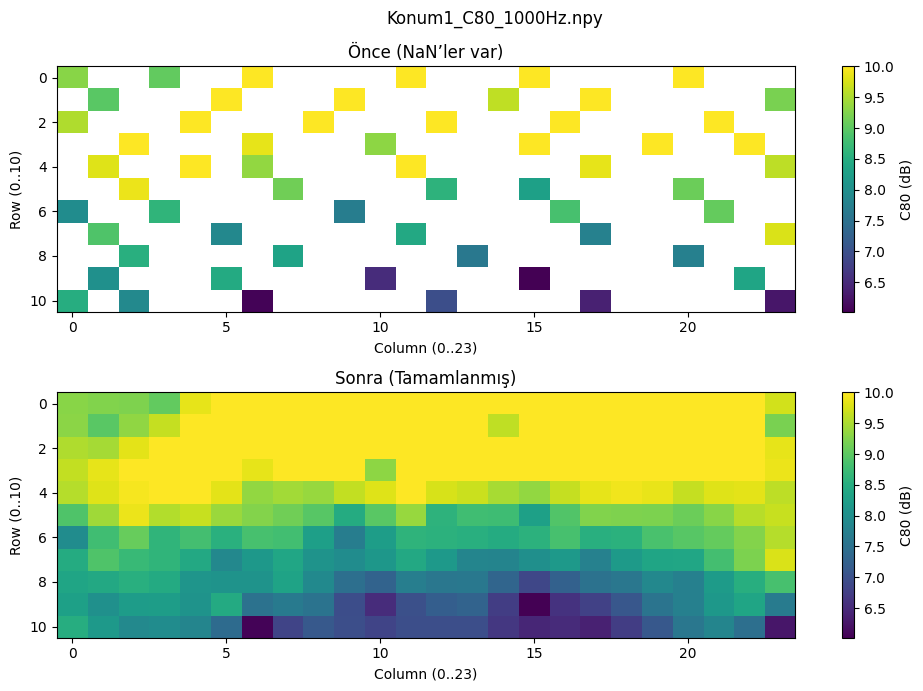

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_1000Hz_before_after.png


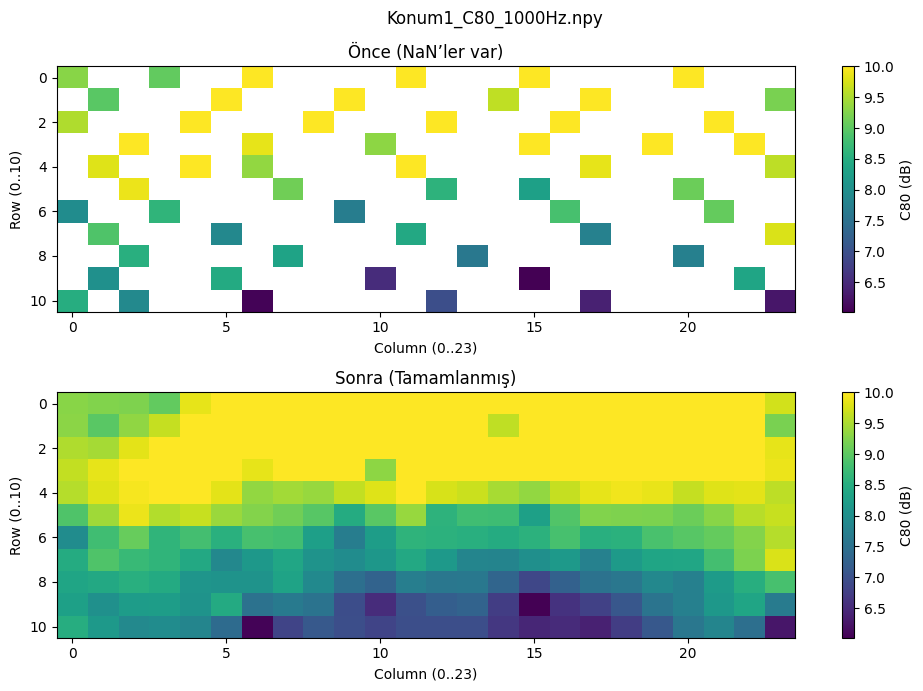

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_125Hz_before_after.png


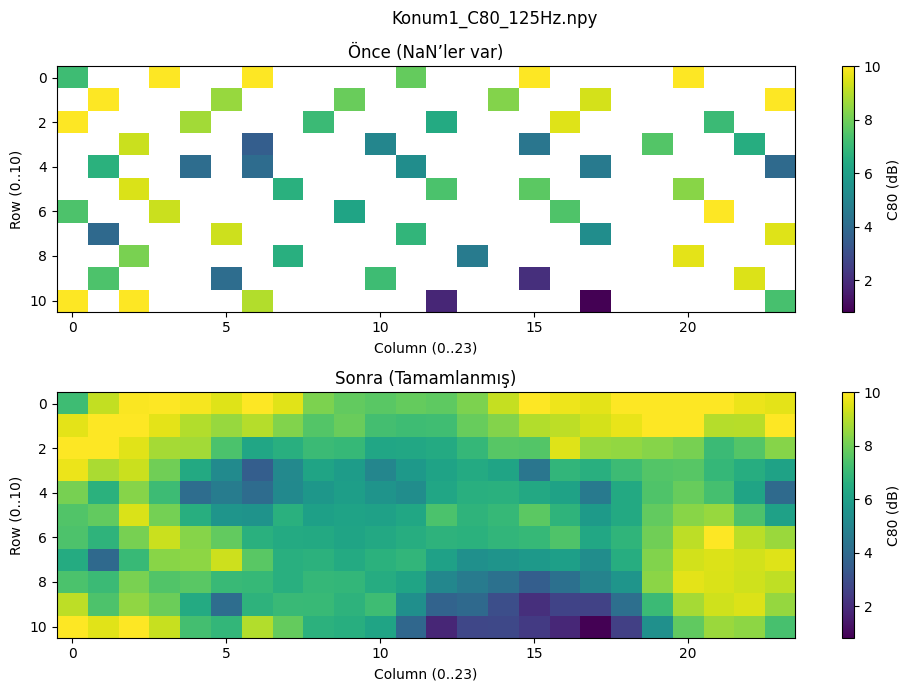

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_2000Hz_before_after.png


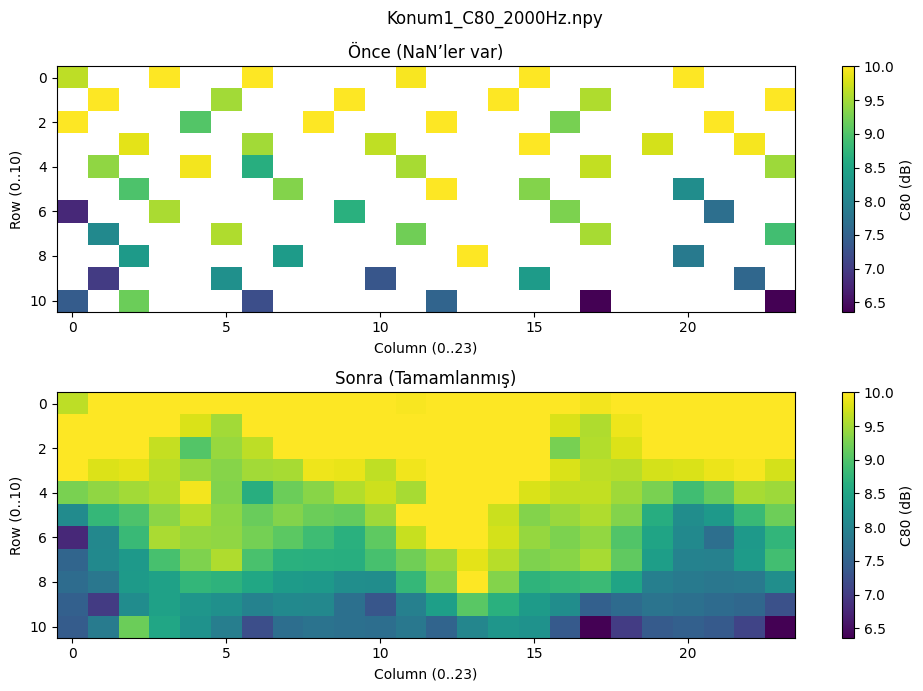

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_250Hz_before_after.png


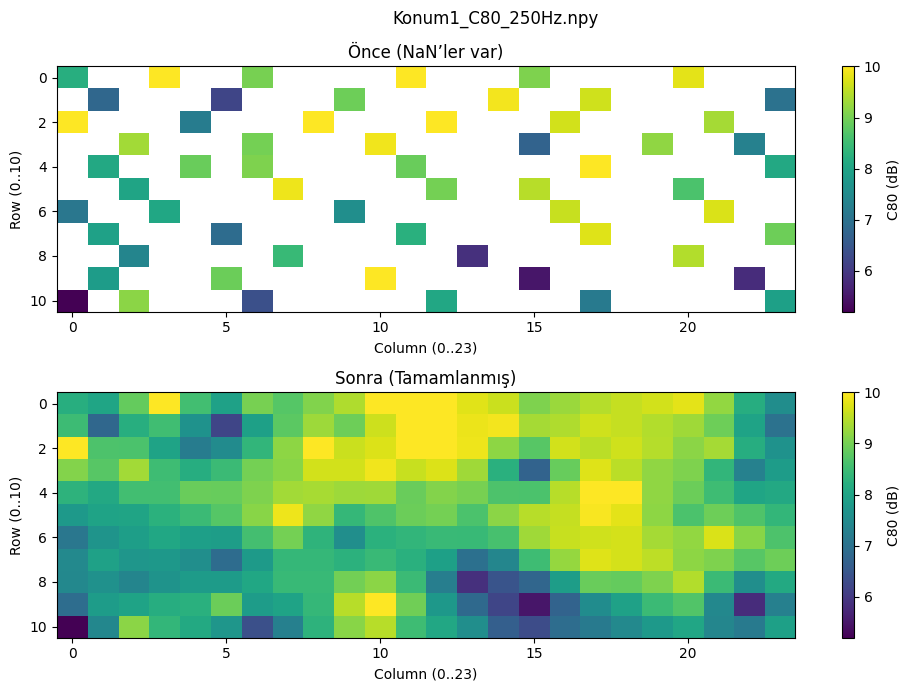

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_4000Hz_before_after.png


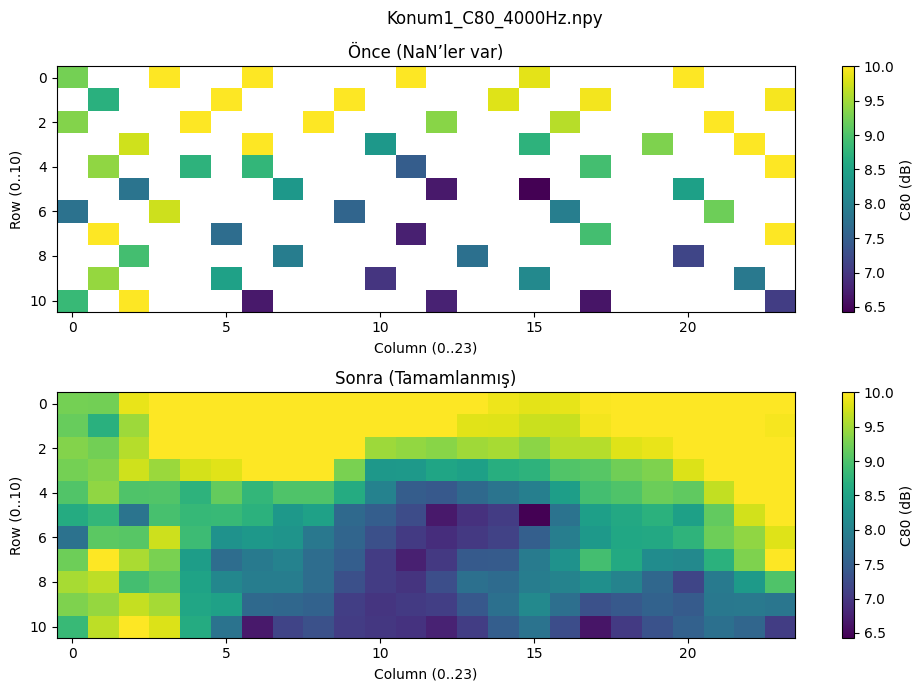

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum1_C80_500Hz_before_after.png


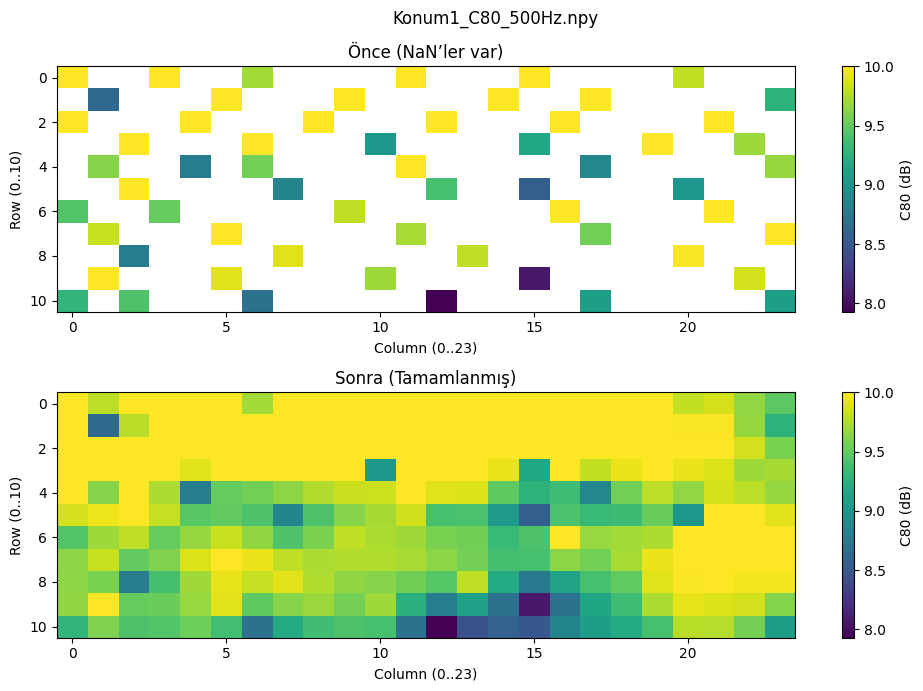

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum2_C80_1000Hz_before_after.png


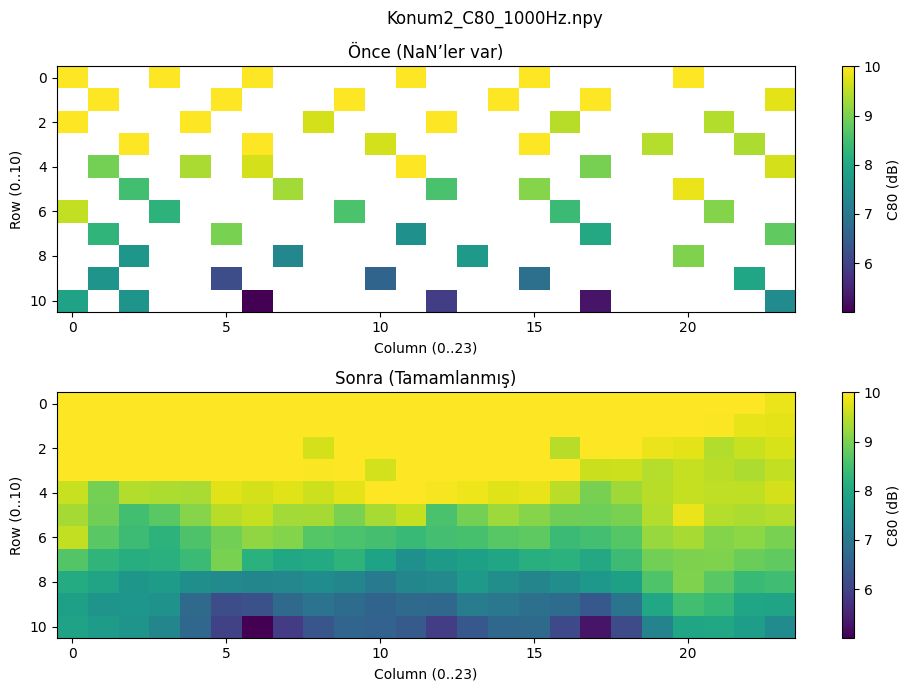

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum2_C80_125Hz_before_after.png


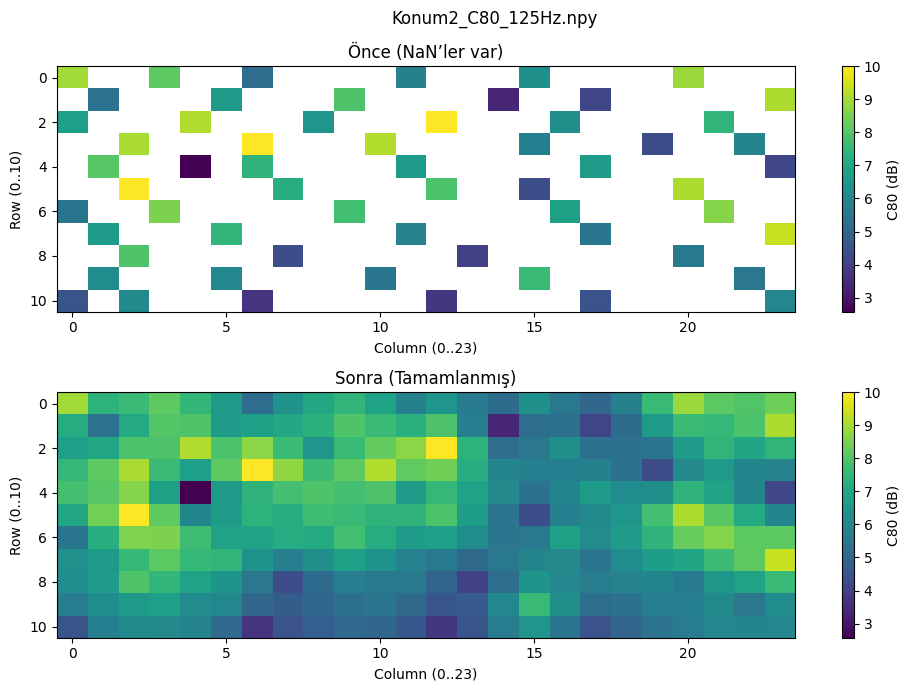

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum2_C80_2000Hz_before_after.png


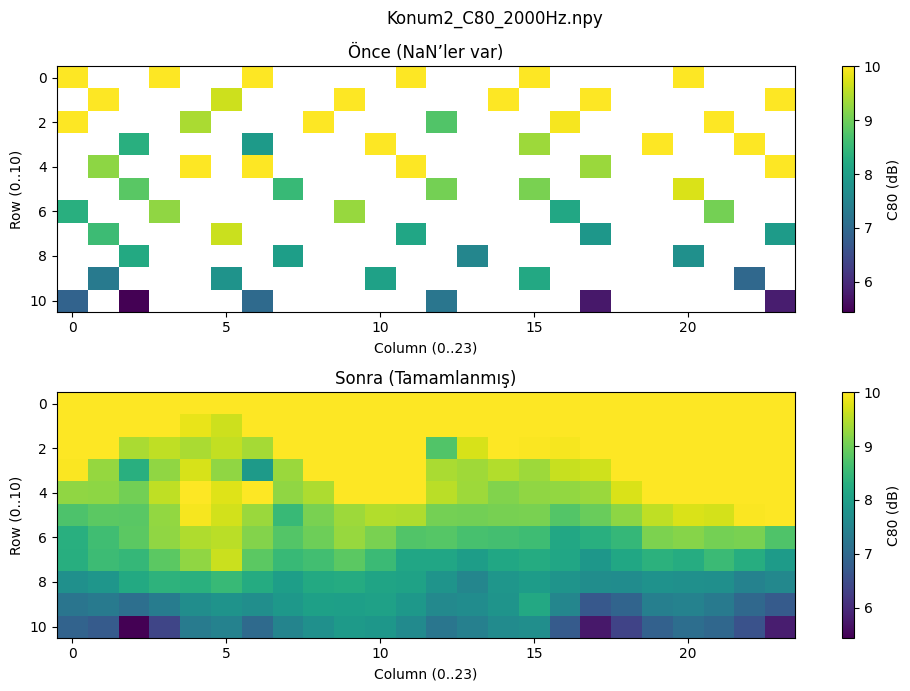

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum2_C80_250Hz_before_after.png


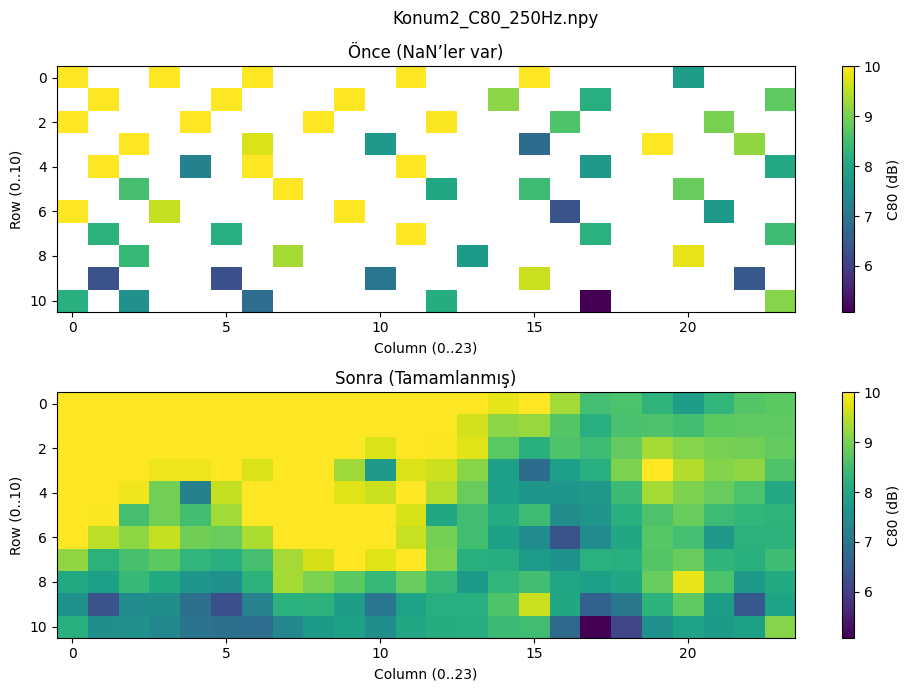

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum2_C80_4000Hz_before_after.png


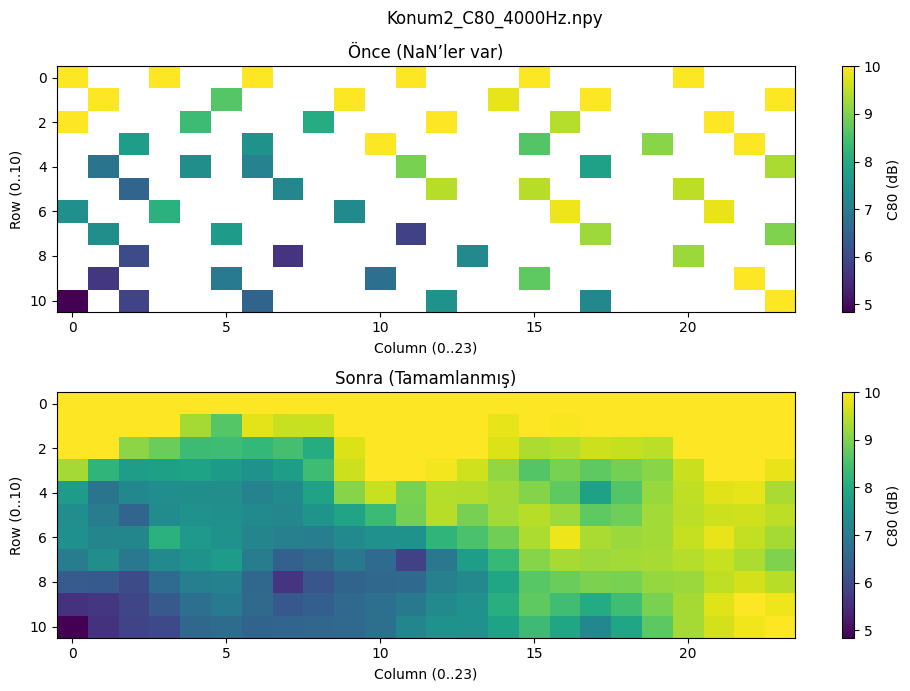

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum2_C80_500Hz_before_after.png


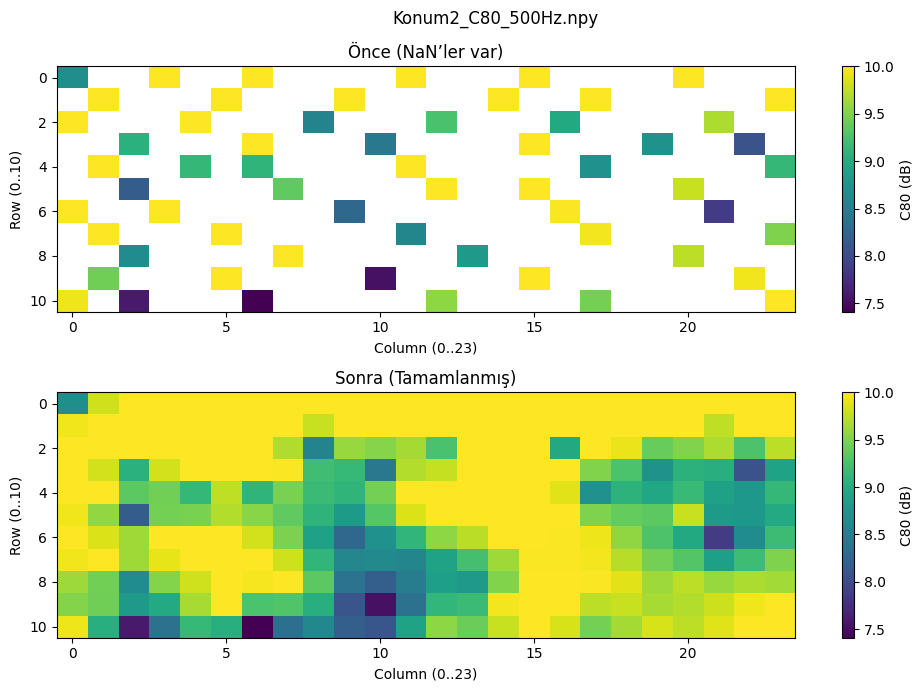

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum3_C80_1000Hz_before_after.png


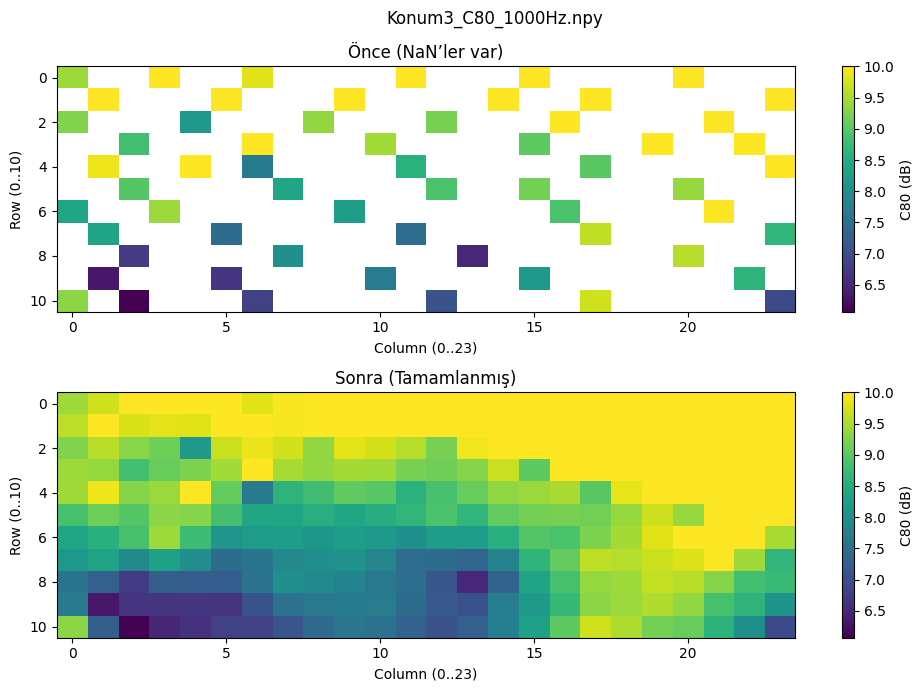

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum3_C80_125Hz_before_after.png


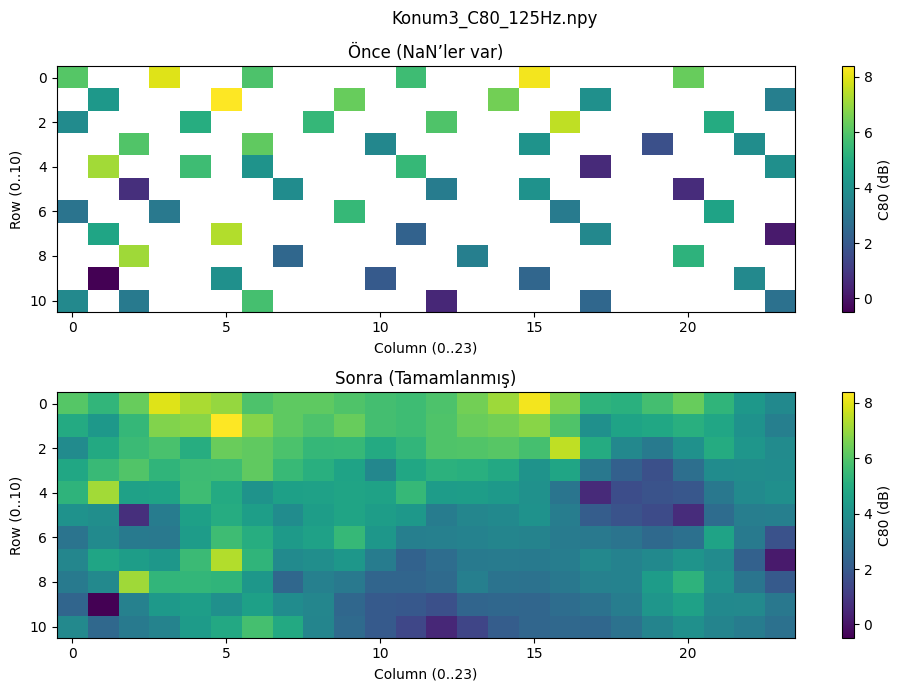

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum3_C80_2000Hz_before_after.png


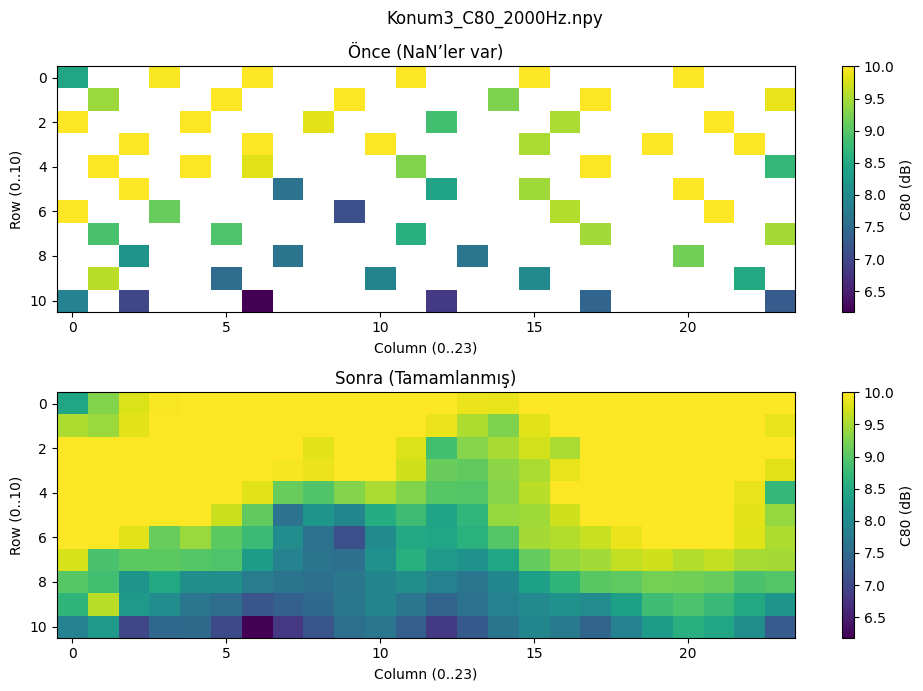

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum3_C80_250Hz_before_after.png


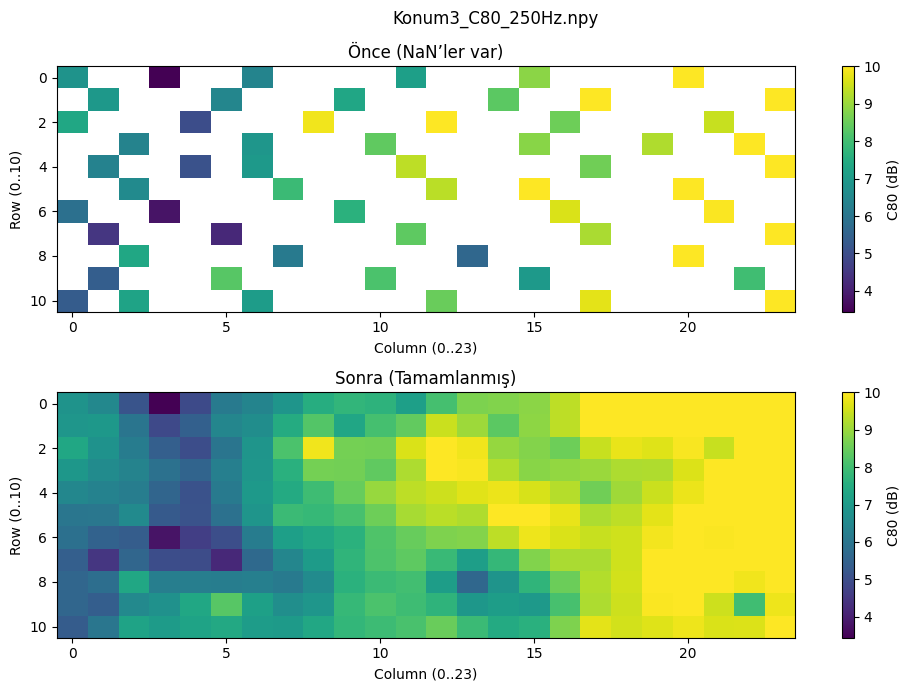

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum3_C80_4000Hz_before_after.png


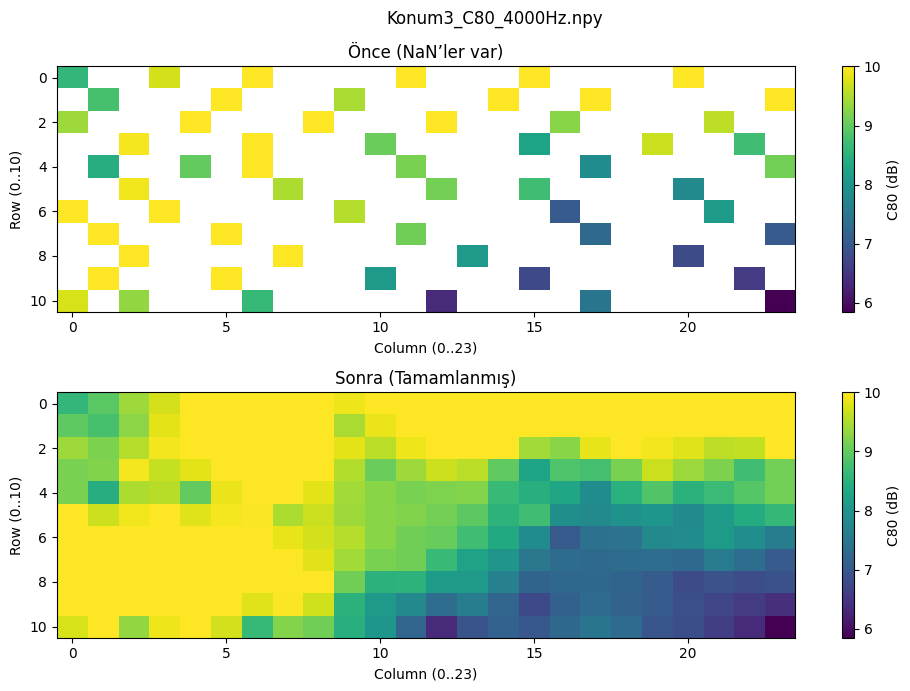

Kaydedildi -> /content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps/Konum3_C80_500Hz_before_after.png


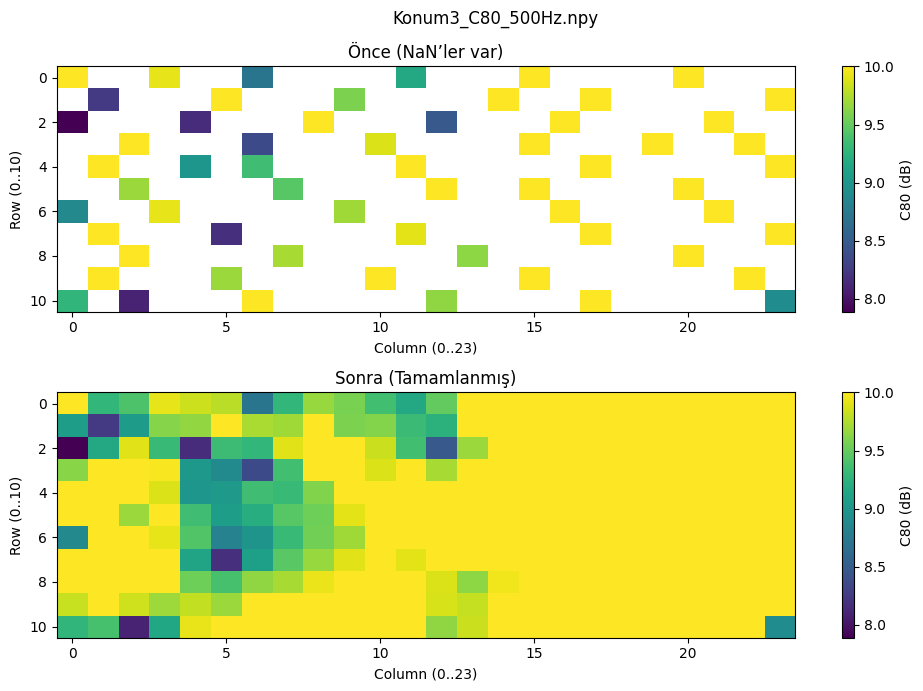

In [18]:
# === BEFORE / AFTER C80 HEATMAP (Colab) ===
import os, glob, numpy as np
import matplotlib.pyplot as plt

# ---- YOLLAR: KENDİNE GÖRE DÜZENLE ----
ORIG_DIR       = "/content/drive/MyDrive/Task_2"  # orijinal .npy'lerin kökü (alt klasörleri de taranır)
COMPLETED_DIR  = "/content/drive/MyDrive/Acoustic_C80_Project/outputs_completed"  # tamamlanmışların kaydedildiği klasör
SAVE_DIR       = "/content/drive/MyDrive/Acoustic_C80_Project/reports/heatmaps"   # PNG'leri kaydetmek için
os.makedirs(SAVE_DIR, exist_ok=True)

N_ROWS, N_COLS = 11, 24   # salon ızgarası

def find_all_npy(root):
    paths = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(".npy"):
                paths.append(os.path.join(r, f))
    return sorted(paths)

def completed_path_for(orig_fp):
    """
    Tamamlanmış dosya adını, orijinalin adına göre türet:
    Örn: Konum1_C80_1000Hz.npy -> Konum1_C80_1000Hz__completed.npy
    """
    base = os.path.splitext(os.path.basename(orig_fp))[0]
    cand = os.path.join(COMPLETED_DIR, base + "__completed.npy")
    return cand

def load_before_after(orig_fp, comp_fp):
    d0 = np.load(orig_fp, allow_pickle=True).item()
    am_before = d0["acoustic_matrix"].astype(np.float32)

    d1 = np.load(comp_fp, allow_pickle=True).item()
    # Tercihen 'acoustic_matrix_completed' vardır:
    if "acoustic_matrix_completed" in d1:
        am_after = d1["acoustic_matrix_completed"].astype(np.float32)
    else:
        # yoksa aynı dosyada 'acoustic_matrix' tamamlanmış olabilir
        am_after = d1["acoustic_matrix"].astype(np.float32)

    assert am_before.shape == (N_ROWS, N_COLS) and am_after.shape == (N_ROWS, N_COLS)
    return am_before, am_after

def plot_before_after(am_before, am_after, title, save_path=None):
    # Ortak renk aralığı: veriden al, [-10, 10] ile makul clamp
    vmin = float(np.nanmin([np.nanmin(am_before), np.nanmin(am_after)]))
    vmax = float(np.nanmax([np.nanmax(am_before), np.nanmax(am_after)]))
    vmin = max(vmin, -10.0)
    vmax = min(vmax,  10.0)
    if vmin >= vmax:  # güvenlik
        vmin, vmax = -10.0, 10.0

    fig, axes = plt.subplots(2, 1, figsize=(10, 7))

    im1 = axes[0].imshow(am_before, aspect='auto', origin='upper', vmin=vmin, vmax=vmax, cmap='viridis')
    axes[0].set_title("Önce (NaN’ler var)")
    axes[0].set_xlabel("Column (0..23)")
    axes[0].set_ylabel("Row (0..10)")
    c1 = plt.colorbar(im1, ax=axes[0]); c1.set_label("C80 (dB)")

    im2 = axes[1].imshow(am_after, aspect='auto', origin='upper', vmin=vmin, vmax=vmax, cmap='viridis')
    axes[1].set_title("Sonra (Tamamlanmış)")
    axes[1].set_xlabel("Column (0..23)")
    axes[1].set_ylabel("Row (0..10)")
    c2 = plt.colorbar(im2, ax=axes[1]); c2.set_label("C80 (dB)")

    plt.suptitle(title, y=0.98, fontsize=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=160)
        print("Kaydedildi ->", save_path)
    plt.show()

# ---- 1) TEK DOSYA ÖRNEĞİ (ilk bulunan) ----
orig_files = find_all_npy(ORIG_DIR)
if not orig_files:
    raise RuntimeError(f"'{ORIG_DIR}' altında .npy bulunamadı.")

sample_orig = orig_files[0]
sample_comp = completed_path_for(sample_orig)
if not os.path.exists(sample_comp):
    raise FileNotFoundError(f"Tamamlanmış dosya yok: {sample_comp}")

b, a = load_before_after(sample_orig, sample_comp)
plot_before_after(b, a, title=os.path.basename(sample_orig),
                  save_path=os.path.join(SAVE_DIR, os.path.splitext(os.path.basename(sample_orig))[0] + "_before_after.png"))

# ---- 2) TÜM DOSYALAR İÇİN TOPLU KAYDETME (isteğe bağlı) ----
DO_BATCH = True  # istemezsen False yap
if DO_BATCH:
    for orig_fp in orig_files:
        comp_fp = completed_path_for(orig_fp)
        if not os.path.exists(comp_fp):
            # bazı orijinal dosyaların tamamlanmışı farklı klasörde/isimde olabilir
            # gerekirse burayı kendine göre uyarlarsın
            print("Atlandı (tamamlanmış yok):", os.path.basename(orig_fp))
            continue
        before, after = load_before_after(orig_fp, comp_fp)
        out_png = os.path.join(SAVE_DIR, os.path.splitext(os.path.basename(orig_fp))[0] + "_before_after.png")
        plot_before_after(before, after, title=os.path.basename(orig_fp), save_path=out_png)